# Anti-pruritic peptide discovery

This notebook analyzes the peptides that had BLASTp hits against known anti-pruritic peptides.
It joins these predictions to other metadata to see if there are additional signals that we can leverage to know that the peptides do have anti-pruritic activity.

## Notebook set up

In [1]:
library(tidyverse)

── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
setwd("..")

In [3]:
# adjust plot size rendered inline
options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 300)

## Functions

In [4]:
# get FASTA sequence names from a FASTA file as a data frame
read_fasta_names <- function(file_path) {
  lines <- read_lines(file_path)
  
  # Filter lines that start with '>'
  filtered_lines <- lines[str_detect(lines, "^>")]
  
  tibble(peptide_name = filtered_lines) %>%
    mutate(peptide_name = gsub(" .*", "", peptide_name),
           peptide_name = gsub("^>", "", peptide_name))
}

## Read in data

In [5]:
# read in BLASTp results for peptigate predictions vs. 5 known antipruritic peptides
antip <- read_tsv("outputs/analysis/predict_antipruritic.tsv", show_col_types = FALSE) %>%
  # select only one blast hit for each query peptide
  group_by(qseqid) %>%
  slice_max(bitscore) %>%
  slice_min(evalue) %>%
  slice_head(n = 1) %>%
  ungroup()

In [6]:
# get anti-pruritic peptide names and types (these are the peptides that made up the BLAST database with known anti-pruritic activity)
antip_names <- Sys.glob("inputs/antipruritic_peptides/*faa.gz") %>%
  set_names() %>%
  map_dfr(read_fasta_names, .id = "antipruritic_peptide") %>%
  mutate(antipruritic_peptide = gsub(".faa.gz", "", basename(antipruritic_peptide)))

In [7]:
# read in BLASTp results for peptigate vs. known human peptides
matching_human <- read_tsv("outputs/analysis/compare_human/humanpeptideatlas_blastp_matches.tsv", show_col_types = FALSE) %>%
  group_by(qseqid) %>%
  slice_max(bitscore) %>%
  slice_min(evalue) %>%
  slice_head(n = 1) %>%
  ungroup() %>%
  rename_with(~paste0("humanpeptideatlas_blast_", .x))

In [8]:
# read in peptigate results
peptigate <- Sys.glob("outputs/tsa_tick_sg_transcriptomes/*/predictions/peptide_predictions.tsv") %>%
  map_dfr(read_tsv, show_col_types = FALSE)  %>%
  rename_with(~paste0("peptigate_", .x))

In [9]:
# read in cleavage peptide parent protein annotations by eggnog
eggnog <- read_tsv("outputs/analysis/annotate_cleavage_parent_proteins/eggnog.emapper.annotations",
                   comment = "##", show_col_types = FALSE) %>%
  rename(query = `#query`) %>%
  group_by(query) %>%
  slice_min(evalue) %>%
  slice_max(score) %>%
  slice_head(n = 1) %>%
  ungroup() %>%
  rename_with(~paste0("parent_protein_eggnog_", .x))

In [10]:
# read in autopeptideml anti-inflammatory predictions
apml_antiinflammatory <- read_tsv("outputs/analysis/predict_antiinflammatory/autopeptideml_antiinflammatory_predictions.tsv",
                                  show_col_types = FALSE) %>%
  select(-sequence)

In [11]:
# read in clustering information
clustering <- read_tsv("outputs/analysis/clustering/all_peptides_0.8_cluster.tsv",
                       show_col_types = FALSE,
                       col_names = c("mmseqs2_representative_sequence",
                                     "mmseqs2_cluster_member"))  %>%
  mutate(mmseqs2_source_representative_txome = ifelse(grepl(pattern = "Transcript_", x = mmseqs2_representative_sequence), 
                                                      "amblyommaamericanum",
                                                      str_extract(mmseqs2_representative_sequence, "G.*?01")),
         mmseqs2_source_cluster_member_txome = ifelse(grepl(pattern = "Transcript_", x = mmseqs2_cluster_member), 
                                                      "amblyommaamericanum",
                                                      str_extract(mmseqs2_cluster_member, "G.*?01")))

In [12]:
# summarize the cluster sizes and whether the clusters have members from multiple transcriptomes
cluster_summary <- clustering %>%
  group_by(mmseqs2_representative_sequence) %>%
  mutate(mmseqs2_cluster_size = n(),
         mmseqs2_cluster_same_txome_count = sum(mmseqs2_source_representative_txome == mmseqs2_source_cluster_member_txome),
         mmseqs2_cluster_same_txome_fraction = mmseqs2_cluster_same_txome_count / mmseqs2_cluster_size) %>%
  ungroup() %>%
  select(mmseqs2_representative_sequence, mmseqs2_cluster_size, mmseqs2_cluster_same_txome_count, mmseqs2_cluster_same_txome_fraction) %>%
  distinct()

In [13]:
# read in transcriptome: species metadata
aa <- data.frame(tsa_accession = "amblyommaamericanum",
                 species = "Amblyomma americanum",
                 bioproject = "PRJNA834823")
metadata <- read_csv("inputs/tick_sg_transcriptomes_tsa.csv", show_col_types = FALSE)
metadata <- bind_rows(metadata, aa) %>%
  select(tsa_accession, species)

New names:
• `` -> `...12`


## Combine together 

In [14]:
antip <- antip %>%
  # join with antipruritic peptide names so its more interpretable
  left_join(antip_names, by = c("sseqid" = "peptide_name")) %>%
  # join with metadata so we know which species each query peptide came from
  mutate(tsa_accession = ifelse(grepl(x = qseqid, pattern = "^G"), 
                                gsub("(G.*?01).*", "\\1", qseqid),
                                "amblyommaamericanum")) %>%
  left_join(metadata, by = c("tsa_accession"), relationship = "many-to-one") %>%
  # join to the peptigate results table so we can filter out duplicate protein sequences
  # and see which tool made the prediction
  left_join(peptigate, by = c("qseqid" = "peptigate_peptide_id")) %>%
  # if the prot seq is duplicated (one is I. ricinus, one in A. americanum),
  # just pick the first sequence
  group_by(peptigate_protein_sequence) %>%
  slice_head(n = 1) %>%
  ungroup() %>%
  # join to human data so we know whether any of these may be human mimics
  left_join(matching_human, by = c("qseqid" = "humanpeptideatlas_blast_qseqid")) %>%
  # reorder columns
  select(qseqid, species, sseqid, antipruritic_peptide, everything()) %>%
  # neither of the two cleavage peptides had hits in KEGG, so I'm not joining to that annotation info here.
  # join to eggnog parent protein annotations
  mutate(parent_protein_id = gsub("_start.*", "", qseqid)) %>%
  left_join(eggnog, by = c("parent_protein_id" = "parent_protein_eggnog_query")) %>%
  # join with anti-inflammatory bioactivity prediction to see if there is an overlap
  left_join(apml_antiinflammatory, by = c("qseqid" = "peptide_id")) %>%
  # join to clustering info to see if any of the peptides are similar to each other
  left_join(clustering, by = c("qseqid" = "mmseqs2_cluster_member")) %>%
  # join to clustering summary to get cluster sizes for peptides
  left_join(cluster_summary, by = "mmseqs2_representative_sequence") %>%
  # remove votucalis, which isn't actually a peptide
  filter(antipruritic_peptide != "votucalis")

## Analyze the results

In [15]:
# how many total sequences had hits to anti-pruritic peptides?
nrow(antip)

[1] 106

In [29]:
# what was the species x peptide hit makeup?

antip %>%
  group_by(antipruritic_peptide) %>%
  tally() 

antip %>%
  group_by(species, antipruritic_peptide) %>%
  tally()

antipruritic_peptide,n
<chr>,<int>
calcitonin_gene-related_peptide,98
dynorphin,8


species,antipruritic_peptide,n
<chr>,<chr>,<int>
Amblyomma americanum,calcitonin_gene-related_peptide,13
Amblyomma americanum,dynorphin,4
Amblyomma cajennense,calcitonin_gene-related_peptide,5
Amblyomma maculatum,calcitonin_gene-related_peptide,3
Amblyomma triste,calcitonin_gene-related_peptide,4
Amblyomma tuberculatum,calcitonin_gene-related_peptide,2
Hyalomma dromedarii,calcitonin_gene-related_peptide,3
Hyalomma excavatum,calcitonin_gene-related_peptide,4
Ixodes ricinus,calcitonin_gene-related_peptide,38


In [17]:
# how many peptides also had hits to the human peptide atlas?
antip %>%
  mutate(humanpeptideatlas_blast_result = ifelse(!is.na(humanpeptideatlas_blast_bitscore), "blast hit", "no blast hit")) %>%
  group_by(humanpeptideatlas_blast_result) %>%
  tally()

humanpeptideatlas_blast_result,n
<chr>,<int>
blast hit,78
no blast hit,28


In [18]:
# how many peptides also had hits to the human peptide atlas?
antip %>%
  mutate(humanpeptideatlas_blast_result = ifelse(!is.na(humanpeptideatlas_blast_bitscore), "blast hit", "no blast hit")) %>%
  group_by(species, antipruritic_peptide, humanpeptideatlas_blast_result) %>%
  tally()


species,antipruritic_peptide,humanpeptideatlas_blast_result,n
<chr>,<chr>,<chr>,<int>
Amblyomma americanum,calcitonin_gene-related_peptide,blast hit,9
Amblyomma americanum,calcitonin_gene-related_peptide,no blast hit,4
Amblyomma americanum,dynorphin,blast hit,2
Amblyomma americanum,dynorphin,no blast hit,2
Amblyomma cajennense,calcitonin_gene-related_peptide,blast hit,5
Amblyomma maculatum,calcitonin_gene-related_peptide,blast hit,3
Amblyomma triste,calcitonin_gene-related_peptide,blast hit,4
Amblyomma tuberculatum,calcitonin_gene-related_peptide,blast hit,2
Hyalomma dromedarii,calcitonin_gene-related_peptide,blast hit,1


In [19]:
# how similar are these sequences at an 80% percent identity?
nrow(antip)
length(unique(antip$mmseqs2_representative_sequence))

[1] 106

[1] 85

In [20]:
antip %>%
  group_by(species, antipruritic_peptide, mmseqs2_representative_sequence) %>%
  tally()

species,antipruritic_peptide,mmseqs2_representative_sequence,n
<chr>,<chr>,<chr>,<int>
Amblyomma americanum,calcitonin_gene-related_peptide,GBZX01001211.1,1
Amblyomma americanum,calcitonin_gene-related_peptide,GBZX01002850.1,1
Amblyomma americanum,calcitonin_gene-related_peptide,GJDI01015779.1,1
Amblyomma americanum,calcitonin_gene-related_peptide,Transcript_1059608,1
Amblyomma americanum,calcitonin_gene-related_peptide,Transcript_25983,1
Amblyomma americanum,calcitonin_gene-related_peptide,Transcript_295990,1
Amblyomma americanum,calcitonin_gene-related_peptide,Transcript_540011,1
Amblyomma americanum,calcitonin_gene-related_peptide,Transcript_664321,1
Amblyomma americanum,calcitonin_gene-related_peptide,Transcript_828213,1


In [21]:
# how many sequences were cleavage vs. sORF
antip %>%
 group_by(peptigate_peptide_type) %>%
 tally()

peptigate_peptide_type,n
<chr>,<int>
cleavage,2
sORF,104


[1] 30.4

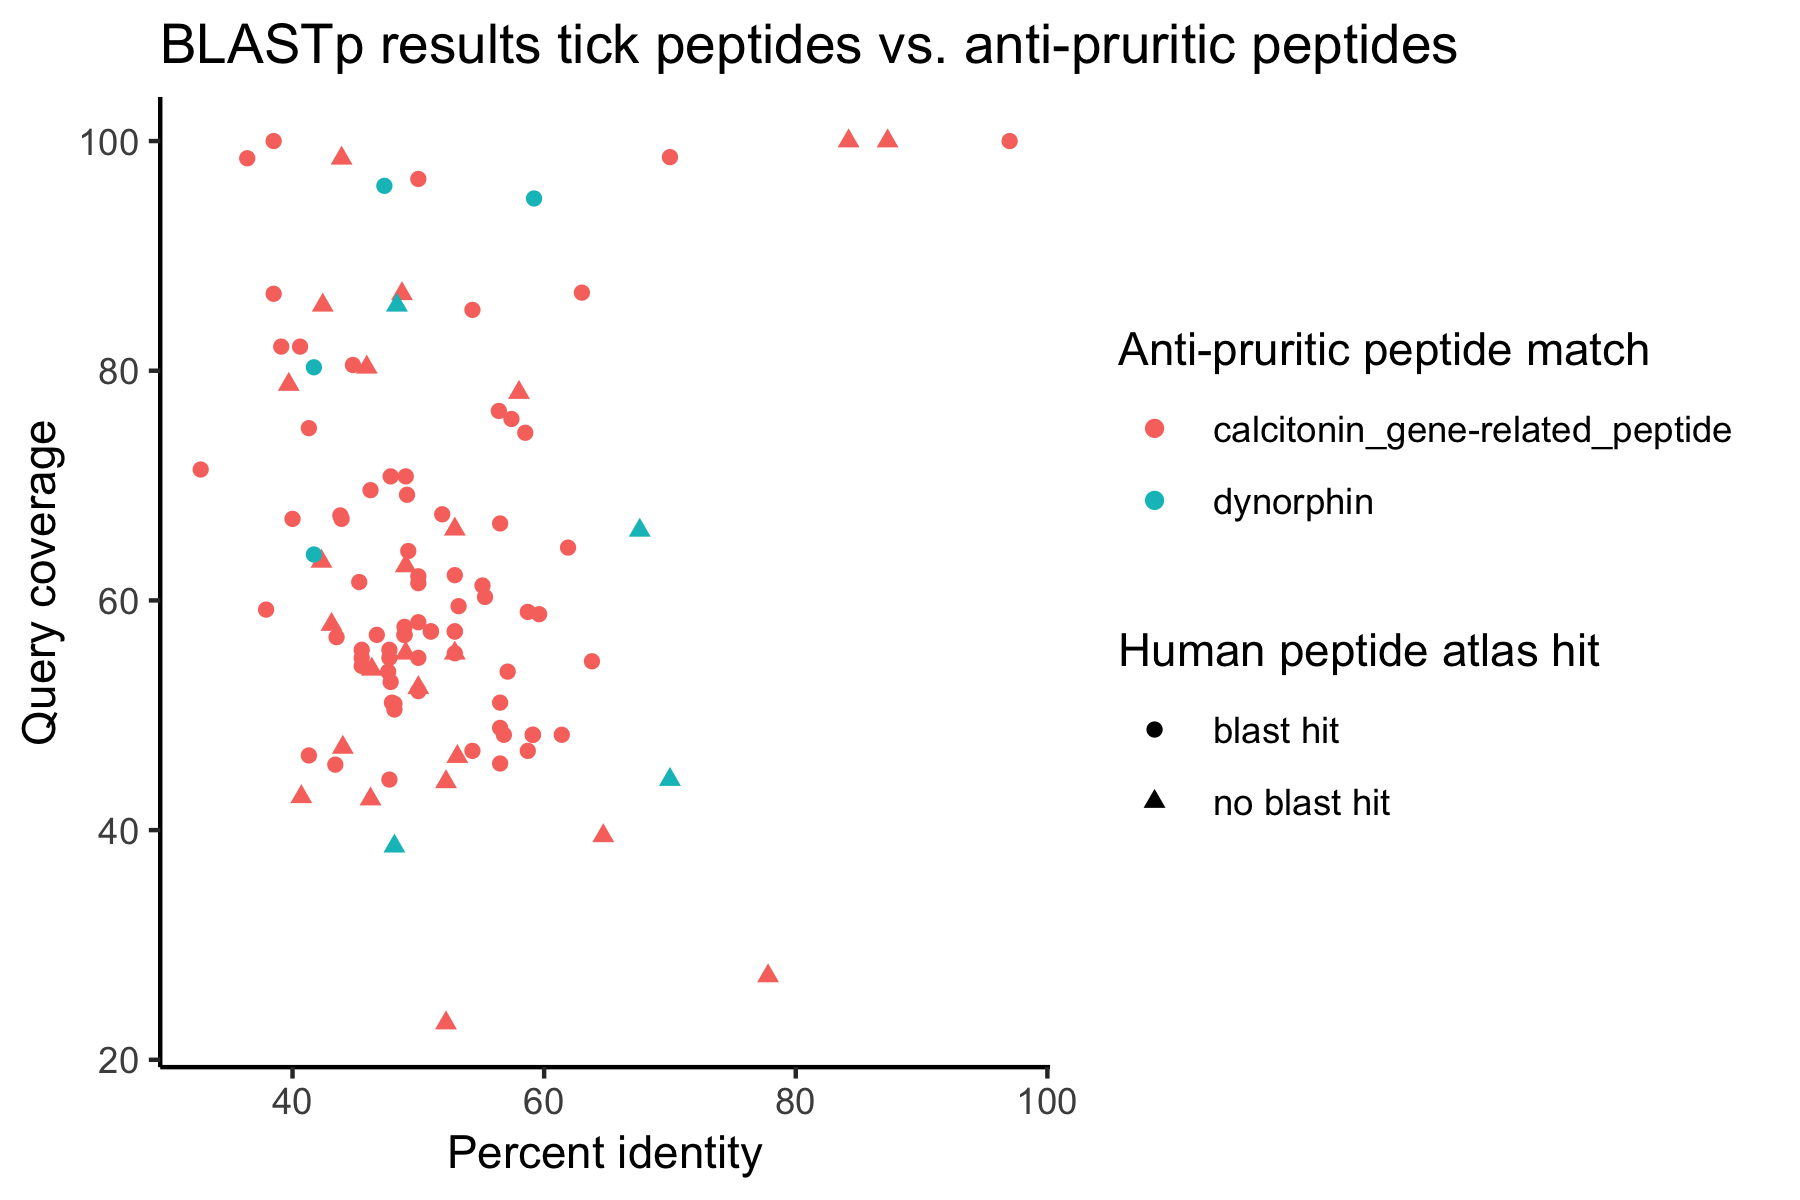

In [22]:
# what do the BLAST hits look like?

ggplot(antip %>%
         mutate(humanpeptideatlas_blast_result = ifelse(!is.na(humanpeptideatlas_blast_bitscore), "blast hit", "no blast hit")),
       aes(x = pident, y = qcovhsp, color = antipruritic_peptide, 
                  shape = humanpeptideatlas_blast_result)) +
  geom_point() +
  theme_classic() +
  labs(x = "Percent identity", y = "Query coverage", shape = "Human peptide atlas hit",
       color = "Anti-pruritic peptide match", title = "BLASTp results tick peptides vs. anti-pruritic peptides")

min(antip$bitscore)

Warning message:
“Removed 28 rows containing missing values or values outside the scale range (`geom_point()`).”


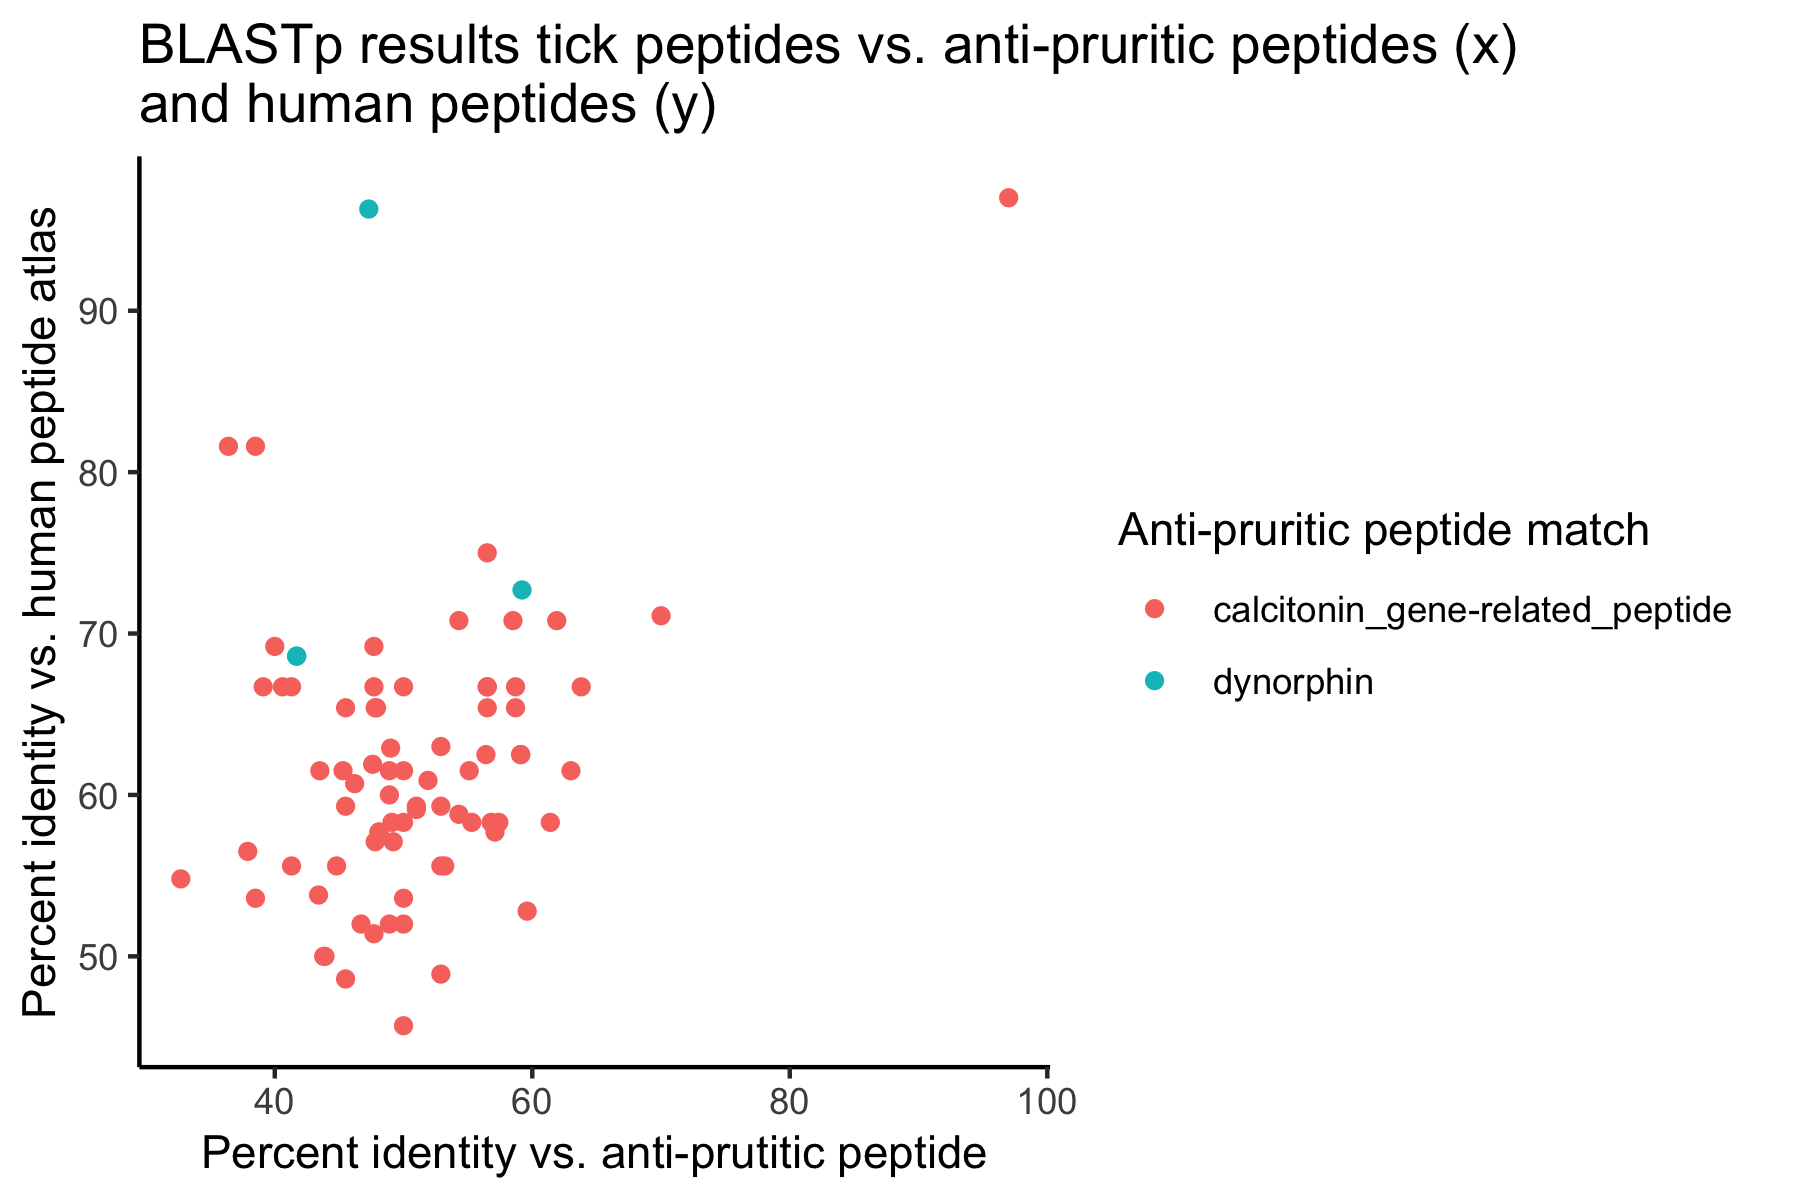

In [23]:
ggplot(antip %>%
         mutate(humanpeptideatlas_blast_result = ifelse(!is.na(humanpeptideatlas_blast_bitscore), "blast hit", "no blast hit")),
       aes(x = pident, y = humanpeptideatlas_blast_pident, color = antipruritic_peptide)) +
  geom_point() +
  theme_classic() +
  labs(x = "Percent identity vs. anti-prutitic peptide",
       y = "Percent identity vs. human peptide atlas",
       color = "Anti-pruritic peptide match",
       title = "BLASTp results tick peptides vs. anti-pruritic peptides (x)\nand human peptides (y)")


In [24]:
antip %>% filter(antipruritic_peptide == "dynorphin") %>%
 select(!starts_with("human"))

qseqid,species,sseqid,antipruritic_peptide,full_sseq,pident,length,qlen,slen,qcovhsp,⋯,parent_protein_eggnog_CAZy,parent_protein_eggnog_BiGG_Reaction,parent_protein_eggnog_PFAMs,antiinflammatory,mmseqs2_representative_sequence,mmseqs2_source_representative_txome,mmseqs2_source_cluster_member_txome,mmseqs2_cluster_size,mmseqs2_cluster_same_txome_count,mmseqs2_cluster_same_txome_fraction
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>
Transcript_513953.p9_start23_end79,Amblyomma americanum,NP_001074026.1,dynorphin,MSAPAQPPAEGTEGAAPGGGPPGPPPNMTSNRRLQQTQAQVEEVVDIMRVNVDKVLERDQKLSELDDRADALQAGASQFESSAAKLKRKYWWKNCKMMIMLGAICAIIVVVIVSKYR,67.6,37,56,117,66.1,⋯,-,-,Synaptobrevin,0.00000000,Transcript_513953.p9_start23_end79,amblyommaamericanum,amblyommaamericanum,1,1,1
GANP01008028.1,Ixodes ricinus,sp|P0DPD6.1|ECE2_HUMAN,dynorphin,MNVALQELGAGSNMVEYKRATLRDEDAPETPVEGGASPDAMEVGKGASPFSPGPSPGMTPGTPRSSGLFWRVTCPHLRSISGLCSRTMVGFQKGTRQLLGSRTQLELVLAGASLLLAALLLGCLVALGVQYHRDPSHSTCLTEACIRVAGKILESLDRGVSPCEDFYQFSCGGWIRRNPLPDGRSRWNTFNSLWDQNQAILKHLLENTTFNSSSEAEQKTQRFYLSCLQVERIEELGAQPLRDLIEKIGGWNITGPWDQDNFMEVLKAVAGTYRATPFFTVYISADSKSSNSNVIQVDQSGLFLPSRDYYLNRTANEKVLTAYLDYMEELGMLLGGRPTSTREQMQQVLELEIQLANITVPQDQRRDEEKIYHKMSISELQALAPSMDWLEFLSFLLSPLELSDSEPVVVYGMDYLQQVSELINRTEPSILNNYLIWNLVQKTTSSLDRRFESAQEKLLETLYGTKKSCVPRWQTCISNTDDALGFALGSLFVKATFDRQSKEIAEGMISEIRTAFEEALGQLVWMDEKTRQAAKEKADAIYDMIGFPDFILEPKELDDVYDGYEISEDSFFQNMLNLYNFSAKVMADQLRKPPSRDQWSMTPQTVNAYYLPTKNEIVFPAGILQAPFYARNHPKALNFGGIGVVMGHELTHAFDDQGREYDKEGNLRPWWQNESLAAFRNHTACMEEQYNQYQVNGERLNGRQTLGENIADNGGLKAAYNAYKAWLRKHGEEQQLPAVGLTNHQLFFVGFAQVWCSVRTPESSHEGLVTDPHSPARFRVLGTLSNSRDFLRHFGCPVGSPMNPGQLCEVW,48.3,60,70,811,85.7,⋯,NA,NA,NA,0.93333333,GANP01008028.1,GANP01,GANP01,1,1,1
Transcript_998879,Amblyomma americanum,sp|P0DPD6.1|ECE2_HUMAN,dynorphin,MNVALQELGAGSNMVEYKRATLRDEDAPETPVEGGASPDAMEVGKGASPFSPGPSPGMTPGTPRSSGLFWRVTCPHLRSISGLCSRTMVGFQKGTRQLLGSRTQLELVLAGASLLLAALLLGCLVALGVQYHRDPSHSTCLTEACIRVAGKILESLDRGVSPCEDFYQFSCGGWIRRNPLPDGRSRWNTFNSLWDQNQAILKHLLENTTFNSSSEAEQKTQRFYLSCLQVERIEELGAQPLRDLIEKIGGWNITGPWDQDNFMEVLKAVAGTYRATPFFTVYISADSKSSNSNVIQVDQSGLFLPSRDYYLNRTANEKVLTAYLDYMEELGMLLGGRPTSTREQMQQVLELEIQLANITVPQDQRRDEEKIYHKMSISELQALAPSMDWLEFLSFLLSPLELSDSEPVVVYGMDYLQQVSELINRTEPSILNNYLIWNLVQKTTSSLDRRFESAQEKLLETLYGTKKSCVPRWQTCISNTDDALGFALGSLFVKATFDRQSKEIAEGMISEIRTAFEEALGQLVWMDEKTRQAAKEKADAIYDMIGFPDFILEPKELDDVYDGYEISEDSFFQNMLNLYNFSAKVMADQLRKPPSRDQWSMTPQTVNAYYLPTKNEIVFPAGILQAPFYARNHPKALNFGGIGVVMGHELTHAFDDQGREYDKEGNLRPWWQNESLAAFRNHTACMEEQYNQYQVNGERLNGRQTLGENIADNGGLKAAYNAYKAWLRKHGEEQQLPAVGLTNHQLFFVGFAQVWCSVRTPESSHEGLVTDPHSPARFRVLGTLSNSRDFLRHFGCPVGSPMNPGQLCEVW,70.0,20,45,811,44.4,⋯,NA,NA,NA,0.80000000,Transcript_998879,amblyommaamericanum,amblyommaamericanum,1,1,1
GFPF01012319.1,Rhipicephalus zambeziensis,sp|A2VDQ5.1|NEUL_BOVIN,dynorphin,MIVQCLLAVRGLHRVGGSRILFRMTLGREEMSPLQAMSSYMAAGRNVLRWDLSPEQIKTRTEELISQTKQVYDAIGMRDIKEVTYENCLQALADIEVKYIVERTMLDFPQHVSSDKEVRAASTEADKRLSRFDIEMSMRQDIFLRIVHLKETCDLEKIKPEARRYLEKSVKMGKRNGLHLPEQVQNEIKAMKKRMSELCIDFNKNLNEDDTFLVFSKAELGALPDDFINSLEKTDGDKYKITLKYPHYFPVMKKCCVPETRRKMEMAFNTRCKEENTVILQQLLPLRAEVARLLGYSTHADFVLEMNTAKSTRHVTAFLDDLSQKLKPLGEAEREFILNLKKKECKERGFEYDGKINAWDLHYYMTQTEELKYSVDQETLKEYFPIEVVTEGLLNIYQELLGLSFEQVTDAHVWNKSVTLYTVKDKATGEVLGQFYLDLYPREGKYNHAACFGLQPGCLLPDGSRMMSVAALVVNFSQPLAGRPSLLRHDEVRTYFHEFGHVMHQICAQTDFARFSGTNVETDFVEVPSQMLENWVWDADSLRRLSKHYRHGSPITDDLLEKLVASRLVNTGLLTLRQIVLSKVDQSLHTNTALDAASEYAKYCTEILGVAATPGTNMPATFGHLAGGYDGQYYGYLWSEVFSMDMFYSCFKKEGIMNPEVGMKYRNLILKPGGSLDGMDMLQNFLTREPNQKAFLMSRGLPAP,59.2,76,80,704,95.0,⋯,NA,NA,NA,0.13333333,GFPF01012319.1,GFPF01,GFPF01,1,1,1
GBJS01017136.1,Rhipicephalus annulatus,pdb|7Y1F|A,dynorphin,MGCTLSAEDKAAVERSKMIDRNLREDGEKAAREVKLLLLGAGESGKSTIVKQMKIIHEAGYSEEECKQYKAVVYSNTIQSIIAIIRAMGRLKIDFGDSARADDARQLFVLAGAAEEGFMTAELAGVIKRLWKDSGVQACFNRSREYQLNDSAAYYLNDLDRIAQPNYIPTQQDVLRTRVKTTGIVETHFTFKDLHFKMFDVGGQRSERKKWIHCFEGVTAIIFCVALSDYDLVLAEDEEMNRMHESMKLFDSICNNKWFTDTSIILFLNKKDLFEEKIKKSPLTICYPEYAGSNTYEEA

## see how number of peptides changes with different cluster size cut offs

In [25]:
# loop through different cluster size cutoffs and report how many peptides are retained
num_clusters_at_different_cutoffs <- data.frame(cut_off = numeric(), 
                                                num_peptides = numeric(),
                                                num_clusters = numeric())
for(i in 1:15){
    tmp <- antip %>%
      filter(mmseqs2_cluster_size > i)
    num_clusters_at_different_cutoffs[i, 1] <- i + 1
    num_clusters_at_different_cutoffs[i, 2] <- nrow(tmp)
    num_clusters_at_different_cutoffs[i, 3] <- length(unique(tmp$mmseqs2_representative_sequence))
}

In [26]:
num_clusters_at_different_cutoffs

,cut_off,num_peptides,num_clusters
,<dbl>,<dbl>,<dbl>
1,2,43,22
2,3,24,10
3,4,13,6
4,5,7,4
5,6,2,2
6,7,2,2
7,8,1,1
8,9,1,1
9,10,1,1


In [27]:
# save the anti-pruritic peptide and metdata to a TSV
write_tsv(antip, "outputs/analysis/20240626_filtered_antipruritic_with_metadata.tsv")

In [28]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /Users/taylorreiter/miniconda3/envs/tidyjupyter/lib/libopenblasp-r0.3.26.dylib;  LAPACK version 3.12.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/New_York
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] lubridate_1.9.3 forcats_1.0.0   stringr_1.5.1   dplyr_1.1.4    
 [5] purrr_1.0.2     readr_2.1.5     tidyr_1.3.1     tibble_3.2.1   
 [9] ggplot2_3.5.0   tidyverse_2.0.0

loaded via a namespace (and not attached):
 [1] bit_4.0.5        gtable_0.3.4     jsonlite_1.8.8   compiler_4.3.3  
 [5] crayon_1.5.2     tidyselect_1.2.0 IRdisplay_1.1    parallel_4.3.3  
 [9] scales_1.3.0     uuid_1.2-0       fastmap_1.1.1    IRkernel_1.3.2  
[13] R6_2.5.1         labeling_0.4.3   generics_0.1.3 